In [42]:
import matplotlib.pyplot as plt
import numpy as np
from CentralStreamingModel.utils.read_probabilities import VD, VD_los
from pyprojection import projection_parallel as pj
import importlib
from CentralStreamingModel.integral.real2redshift  import compute_integrand, compute_integrand_continuous, integrate
import pickle
from CentralStreamingModel.tpcfs.tpcf_tools import get_multipoles, get_wedges
import CentralStreamingModel.biskewt.skewtfit as sf
from CentralStreamingModel.utils.plot_tools import bestfit_jointplot
import CentralStreamingModel.biskewt.skewt as st

In [70]:
boxsize = 2000
box = 1
snapshot  = 11

In [71]:
measured = VD('galaxies', box, boxsize, snapshot)
measured_los = VD_los('galaxies',box, boxsize, snapshot)

In [72]:
rperp_bins = measured_los.r.t
rparallel_bins = measured_los.r.r
vlos_bins = measured_los.v
r_bins = measured.r
vr = measured.v.r
vt = measured.v.t
jointpdf = measured.jointpdf


In [73]:
los_pdf = pj(rperp_bins, rparallel_bins,
                    vlos_bins, r_bins, vr, vt, 
                    jointpdf, interpolate=True, n_cores=10)

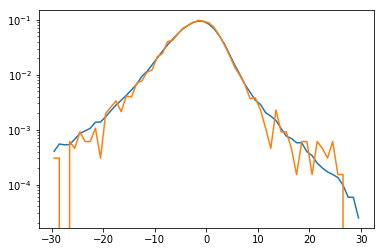

In [74]:
plt.semilogy(vlos_bins, los_pdf[10,10])
plt.semilogy(vlos_bins, measured_los.jointpdf[10,10])

In [75]:
# Compare streaming model from direct measurement to projected

# Load measured real space 2pcf

tpcf_filename = f"/raid/c-cuesta/tpcfs/gals_real_tpcf_box{box}.pickle"

with open(tpcf_filename, "rb") as input_file:

    twopcf_dict = pickle.load(input_file)


In [76]:
def streaming_model(s_paral_full, v_los, real_tpcf_dict, jointpdf_los):
    s = np.arange(0., 50., 1.) 
    s_c = 0.5 * (s[1:] + s[:-1])

    print('Computing streaming integral')
    int_r_parallel, integrand = compute_integrand(s, s, 
            real_tpcf_dict, jointpdf_los, s_paral_full, v_los)

    
    pi_sigma = integrate(int_r_parallel, integrand)
    
    return s_c, pi_sigma


In [77]:
s_c, pi_sigma_projected = streaming_model(rparallel_bins, vlos_bins, twopcf_dict, los_pdf )

Computing streaming integral


In [78]:
s_c, pi_sigma = streaming_model(rparallel_bins, vlos_bins, twopcf_dict, measured_los.jointpdf )

Computing streaming integral


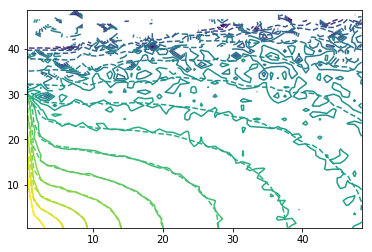

In [79]:
levels = np.arange(-4, 1, 0.3)
plt.contour(s_c, s_c, np.log10(pi_sigma).T, levels=levels)
plt.contour(s_c, s_c, np.log10(pi_sigma_projected).T, levels=levels, linestyles='dashed')

In [80]:
s = np.arange(0., 50., 1.) 

n_mu_bins = 120
mu_bins = np.linspace(0.,1.,n_mu_bins)

s_mu, monopole, quadrupole, hexadecapole = \
            get_multipoles(s, pi_sigma, s, mu_bins)


s_mu_projected, monopole_projected, quadrupole_projected, hexadecapole_projected = \
            get_multipoles(s, pi_sigma_projected, s, mu_bins)




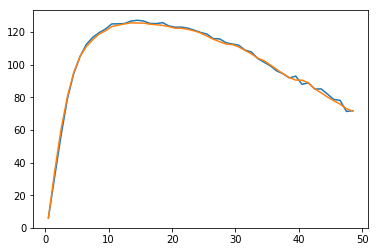

In [81]:
plt.plot(s_c, s_c*s_c*monopole)
plt.plot(s_c, s_c*s_c*monopole_projected)

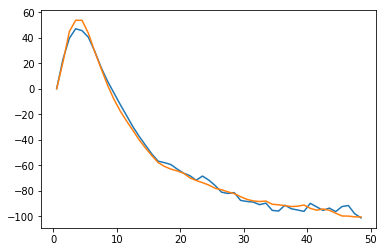

In [82]:
plt.plot(s_c, s_c*s_c*quadrupole)
plt.plot(s_c, s_c*s_c*quadrupole_projected)

In [83]:
n_wedges = 5
wedges_bins = np.linspace(0.,1, n_wedges + 1)

wedges = get_wedges(s_c, s_mu, mu_bins, wedges_bins)

wedges_projected = get_wedges(s_c, s_mu_projected, mu_bins, wedges_bins)


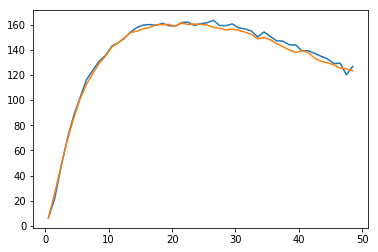

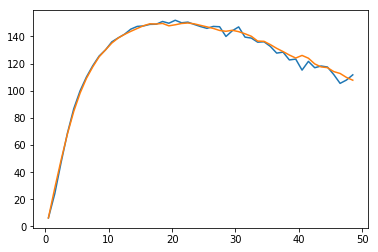

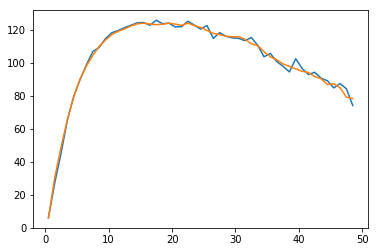

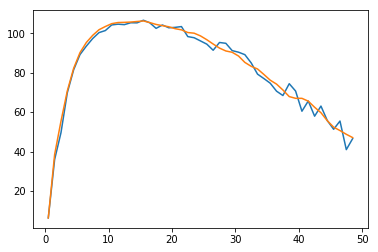

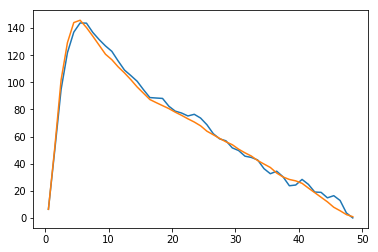

In [84]:
for i in range(len(wedges)):
    plt.plot(s_c, s_c*s_c*wedges[i])
    plt.plot(s_c, s_c*s_c*wedges_projected[i])
    plt.show()

## Compare python code to C code

In [85]:
import importlib
importlib.reload(sf)

<module 'CentralStreamingModel.biskewt.skewtfit' from '/home/c-cuesta/CentralStreamingModel/biskewt/skewtfit.py'>

In [86]:
popt, pcov = sf.radial_tangential_read_skewtfit('galaxies',boxsize, box, 
                                           snapshot,False)

In [155]:
v_r = measured.v.r
v_t = measured.v.t

r = np.arange(0.5, 100, 1.)

v = np.array(np.meshgrid(v_r, v_t)).T.reshape(-1,2)

skewt = []
for rbin in range(len(r)):
    modified_popt = popt[rbin].copy()
    modified_popt[-1] -= 1
    skewt.append(st.skewt(v, *modified_popt).reshape(v_t.shape[0], v_r.shape[0]))

skewt = np.asarray(skewt)


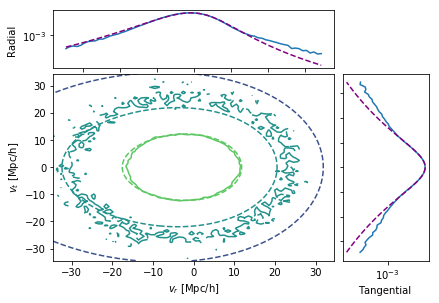

In [156]:
rbin= 35
bestfit_jointplot(v_r, v_t, measured.jointpdf[rbin], 
                  skewt[rbin], log=True, log_marginals=True)

In [157]:
st_los_pdf = pj(rperp_bins, rparallel_bins,
                    vlos_bins, r_bins, vr, vt, 
                    skewt, interpolate=True, n_cores=10)

In [158]:
s_c, pi_sigma_st = streaming_model(rparallel_bins, vlos_bins, twopcf_dict, st_los_pdf )

Computing streaming integral


In [159]:
s_mu_st, monopole_st, quadrupole_st, hexadecapole_st = \
            get_multipoles(s, pi_sigma_st, s, mu_bins)


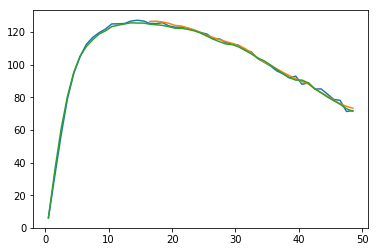

In [160]:
plt.plot(s_c, s_c*s_c*monopole)
plt.plot(s_c, s_c*s_c*monopole_st)

plt.plot(s_c, s_c*s_c*monopole_projected)

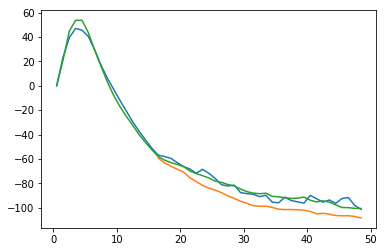

In [161]:
plt.plot(s_c, s_c*s_c*quadrupole)
plt.plot(s_c, s_c*s_c*quadrupole_st)
plt.plot(s_c, s_c*s_c*quadrupole_projected)

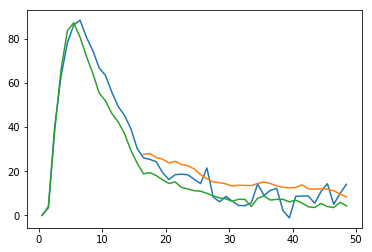

In [162]:
plt.plot(s_c, s_c*s_c*hexadecapole)
plt.plot(s_c, s_c*s_c*hexadecapole_st)
plt.plot(s_c, s_c*s_c*hexadecapole_projected)

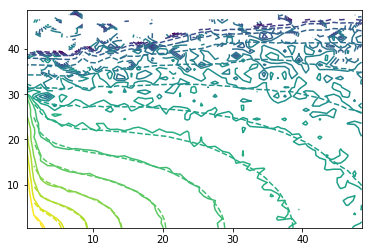

In [163]:
levels = np.arange(-4, 1, 0.3)
plt.contour(s_c, s_c, np.log10(pi_sigma).T, levels=levels)
plt.contour(s_c, s_c, np.log10(pi_sigma_st).T, levels=levels, linestyles='dashed')

In [164]:
wedges_st = get_wedges(s_c, s_mu_st, mu_bins, wedges_bins)


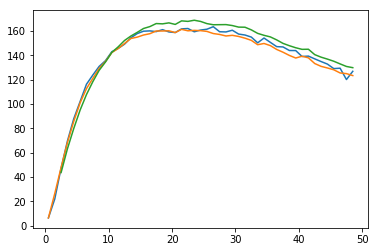

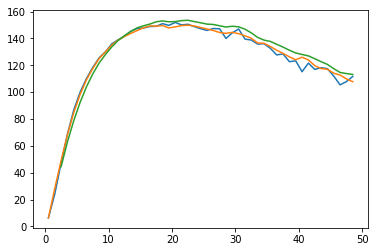

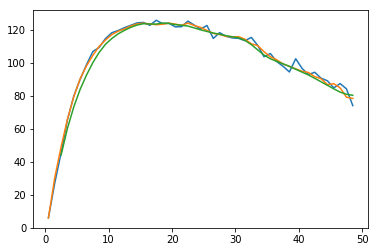

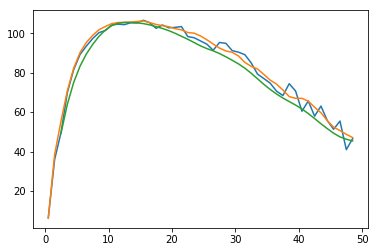

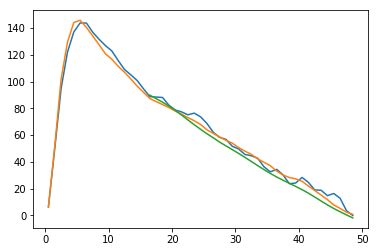

In [165]:
for i in range(len(wedges)):
    plt.plot(s_c, s_c*s_c*wedges[i])
    plt.plot(s_c, s_c*s_c*wedges_projected[i])
    plt.plot(s_c, s_c*s_c*wedges_st[i])

    plt.show()